# Astro Lab Book 2025

In [25]:
import astropy
import numpy as np
import ccdproc as ccdp
from pathlib import Path
from astropy.nddata import CCDData
from astropy.stats import mad_std
import astropy.units as u
import matplotlib.pyplot as plt
import warnings
import glob
import os
import photutils.background as photobg
import photutils.segmentation as photoseg
from astropy.convolution import convolve
from photutils.segmentation import SourceCatalog
from photutils.utils import calc_total_error
import photutils.aperture as photoap
from photutils.background import MedianBackground
from scipy.optimize import curve_fit
from astropy.io import fits

warnings.filterwarnings(action='once') #prevents warnings repeating and clogging workspace

In [2]:
biasImg = astropy.nddata.CCDData.read('data/bias/20181101.bias.00000002.fits', unit='adu')
biasimg = np.asarray(biasImg, dtype=np.float64)

def biasavg(biasframe):
    total = 0
    x = len(biasframe)
    y = len(biasframe[0]) #as the array is a square this returns the length of all columns

    for i in range(x):
        for j in range(y):
            total+=biasframe[i][j]

    biasavg = total/(x*y) #mean

    myvar = 0 #filler variable

    for i in range(x):
        for j in range(y):
            myvar+=((biasframe[i][j] - biasavg)**2)

    biasdev = np.sqrt(myvar/(x*y)) #standard deviation

    output = [biasavg, biasdev]
    
    return(output)

biasavg1 = biasavg(biasimg)

print(biasavg1[0])
print(biasavg1[1])

960.1504330039024
8.422060711910369


In [3]:
warnings.filterwarnings('ignore') #this otherwise outputs many, many warnings

calibrated_path_bias = Path('data/bias')
#allbias = ccdp.ImageFileCollection(calibrated_path_bias)
calibrated_biases = glob.glob("data/bias/*.fits")

#calibrated_biases = allbias.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases, #combines all bias frames into my master bias frame
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5, 
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, #the sigma_clip removes any significant outliers from the data
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_bias.meta['combined'] = True

INFO: splitting each image into 11 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


In [4]:
masterbias = np.asarray(combined_bias)

bias = biasavg(masterbias)[0]
read_noise = biasavg(masterbias)[1]

print(bias) #bias
print(read_noise) #read noise

962.9592900923088
5.350563223315935


In [5]:
biasnum = len(calibrated_biases)
biasdev1 = biasavg(biasimg)[1]
biasdevmaster = biasavg(masterbias)[1]

expecteddev = biasdev1 / np.sqrt(biasnum) #what our expected relation gives

print((biasdevmaster - expecteddev)/expecteddev)

0.4205814342237132


In [6]:
alldark = glob.glob("data/darks/*.fits")

for item in alldark:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias) #subtracts bias from each dark frame
    file_name = os.path.basename(item)
    ccd.write(Path('data/calibrated_darks') / file_name, overwrite=True) #writes calibrated dark into new folder

In [7]:
calibrated_darks = glob.glob("data/calibrated_darks/*.fits")

combined_dark = ccdp.combine(calibrated_darks, #combines all dark frames into my master dark frame
                             method='median',  #uses median avg rather than mean                          
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_dark.meta['combined'] = True

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 23 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

In [8]:
dark = np.asarray(combined_dark) #gets the master dark

pixtotal = 0

x = len(dark)
y = len(dark[0]) #as the array is a square this returns the length of all columns

for i in range(x):
    for j in range(y):
        pixtotal+=dark[i][j]

darkcurrentavg = 2.2 * pixtotal/(x*y)

print(f"Dark Current Avg: {darkcurrentavg} e/pix/s") 

Dark Current Avg: 9.393139339485636 e/pix/s


In [9]:
flats_B = glob.glob("data/flat_B/*.flat.*.fits")
flats_R = glob.glob("data/flat_R/*.flat.*.fits")

for item in flats_B:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    ccdp.subtract_bias(ccd, combined_bias)
    file_name = os.path.basename(item)
    ccd.write(Path("data/flat_B_semi-cali") / file_name, overwrite=True)

for item in flats_R:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    ccdp.subtract_bias(ccd, combined_bias)
    file_name = os.path.basename(item)
    ccd.write(Path("data/flat_R_semi-cali") / file_name, overwrite=True)

In [10]:
allflats_B = glob.glob("data/flat_B_semi-cali/*.flat.*.fits")
allflats_R = glob.glob("data/flat_R_semi-cali/*.flat.*.fits")

for item in allflats_B:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time="EXPTIME", exposure_unit=u.second) #CHECK EXPOSURE TIMES
    file_name = os.path.basename(item)
    ccd.write(Path("data/flat_B_cali") / file_name, overwrite=True) #writes calibrated flat frame to new folder

for item in allflats_R:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time="EXPTIME", exposure_unit=u.second) #CHECK EXPOSURE TIMES
    file_name = os.path.basename(item)
    ccd.write(Path("data/flat_R_cali") / file_name, overwrite=True) #writes calibrated flat frame to new folder

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

In [11]:
allcalflats_B = glob.glob("data/flat_B_cali/*.flat.*.fits")
allcalflats_R = glob.glob("data/flat_R_cali/*.flat.*.fits")

for item in allcalflats_B:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    
    total = 0
    mean = 0
    ccdarray = np.asarray(ccd)
    
    for i in range(len(ccdarray)):
        for j in range(len(ccdarray[1])):
            total += ccdarray[i, j]
    
    mean = total / (i*j)

    for i in range(len(ccdarray)):
        for j in range(len(ccdarray[1])):
            ccdarray[i, j] /= mean
    
    ccd = CCDData(ccdarray, unit="adu")
    file_name = os.path.basename(item)
    ccd.write(Path("data/flat_B_norm") / file_name, overwrite=True) #writes normalised flat frame to new folder

for item in allcalflats_R:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    
    total = 0
    mean = 0
    ccdarray = np.asarray(ccd)
    
    for i in range(len(ccdarray)):
        for j in range(len(ccdarray[1])):
            total += ccdarray[i, j]
    
    mean = total / (i*j)

    for i in range(len(ccdarray)):
        for j in range(len(ccdarray[1])):
            ccdarray[i, j] /= mean
    
    ccd = CCDData(ccdarray, unit="adu")
    file_name = os.path.basename(item)
    ccd.write(Path("data/flat_R_norm") / file_name, overwrite=True) #writes normalised flat frame to new folder

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

In [12]:
calibrated_flats_R = glob.glob("data/flat_R_norm/*.flat.*.fits")
calibrated_flats_B = glob.glob("data/flat_B_norm/*.flat.*.fits")

combined_flat_R = ccdp.combine(calibrated_flats_R, #combines all normalised flat frames into my master flat frame
                             method='median',  #uses median avg rather than mean                          
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_flat_B = ccdp.combine(calibrated_flats_B, #combines all normalised flat frames into my master flat frame
                             method='median',  #uses median avg rather than mean                          
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_flat_R.meta['combined'] = True
combined_flat_B.meta['combined'] = True

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 16 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

In [13]:
science_R = glob.glob('data/science_R/*.fits')
science_B = glob.glob('data/science_B/*.fits') 

for frame in science_R:
    
    ccd = astropy.nddata.CCDData.read(frame, unit="adu")
    ccd = ccdp.subtract_bias(ccd, combined_bias) #subtracts master bias from each science frame  
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time='EXPTIME', exposure_unit=u.second, scale=True) #subtracts master dark from each science frame
    file_name = os.path.basename(frame)
    ccd.write(Path("data/science_R_semi-cali") / file_name, overwrite=True) #writes calibrated science frame to new folder

for frame in science_B:
    
    ccd = astropy.nddata.CCDData.read(frame, unit="adu")
    ccd = ccdp.subtract_bias(ccd, combined_bias) #subtracts master bias from each science frame  
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time='EXPTIME', exposure_unit=u.second, scale=True) #subtracts master dark from each science frame
    file_name = os.path.basename(frame)
    ccd.write(Path("data/science_B_semi-cali") / file_name, overwrite=True) #writes calibrated science frame to new folder

In [14]:
semicalibratedscience_R = glob.glob('data/science_R_semi-cali/*.fits')
semicalibratedscience_B = glob.glob('data/science_B_semi-cali/*.fits')

for frame in semicalibratedscience_R:
    
    ccd = astropy.nddata.CCDData.read(frame, unit="adu")
    ccdp.ccd_process(ccd, master_flat=combined_flat_R)
    ccdarray = np.asarray(ccd)
    
    for i in range(len(ccdarray)):
        for j in range(len(ccdarray[1])):
            ccdarray[i, j] *= 2 #doubles exposure time by doubling value in each pixel
    
    ccd = CCDData(ccdarray, unit="adu")
    file_name = os.path.basename(frame)
    
    ccd.write(Path('data/science_R_cali') / file_name, overwrite=True) #writes calibrated science frame to new folder

for frame in semicalibratedscience_B:
    
    ccd = astropy.nddata.CCDData.read(frame, unit="adu")
    ccdp.ccd_process(ccd, master_flat=combined_flat_B)
    ccdarray = np.asarray(ccd)
    
    for i in range(len(ccdarray)):
        for j in range(len(ccdarray[1])):
            ccdarray[i, j] *= 2 #doubles exposure time by doubling value in each pixel
    
    ccd = CCDData(ccdarray, unit="adu")
    file_name = os.path.basename(frame)
    
    ccd.write(Path('data/science_B_cali') / file_name, overwrite=True) #writes calibrated science frame to new folder

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


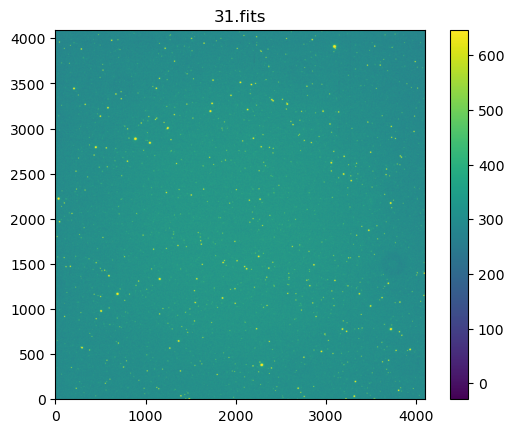

In [15]:
frame31 = astropy.nddata.CCDData.read("data/science_B_cali/20181101.00000031.fits", unit="adu")
plt.imshow(frame31, vmin=-29.470348, vmax=646.92706)
plt.gca().invert_yaxis()
plt.title("31.fits")
plt.colorbar()
plt.show()

In [16]:
array31 = np.asarray(frame31)
x = len(array31)
y = len(array31[0])
print(f"Dimensions = {x}x{y} pixels")

#I found the largest star to be ~40x40 pix so chose the bigbox to be 64x64

Dimensions = 4096x4096 pixels


Background Median = 310.0 adu
Background rms = 59.84645364707618 adu


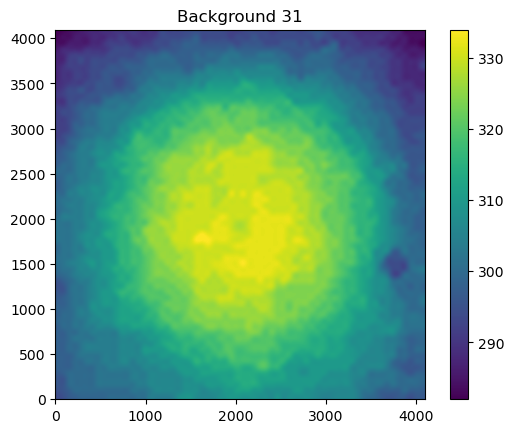

In [17]:
bg31 = photobg.Background2D(frame31, 64, filter_size=3, bkg_estimator=MedianBackground())
bgmedian31 = bg31.background_median
bgrms31 = bg31.background_rms_median
print(f"Background Median = {bgmedian31}")
print(f"Background rms = {bgrms31}")

bgimg31 = bg31.background

plt.imshow(np.asarray(bgimg31), interpolation="nearest")
plt.gca().invert_yaxis()
plt.title("Background 31")
plt.colorbar()
plt.show()

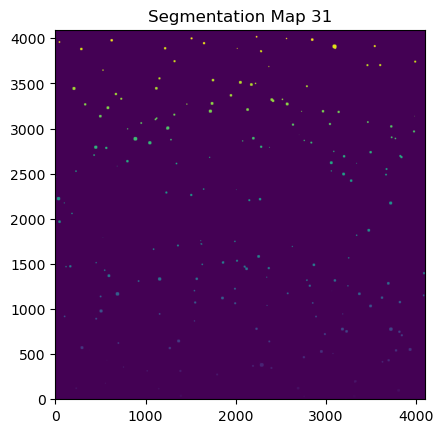

<photutils.segmentation.core.SegmentationImage>
shape: (4096, 4096)
nlabels: 194
labels: [  1   2   3   4   5 ... 190 191 192 193 194]


In [18]:
gaussiankernal31 = photoseg.make_2dgaussian_kernel(25, 25)
threshold31 = bgimg31 + 2 * bgrms31
convolved_data31 = convolve(frame31, gaussiankernal31) * u.adu
segment_map31 = photoseg.detect_sources(convolved_data31, threshold31, npixels=5)

plt.imshow(segment_map31)
plt.gca().invert_yaxis()
plt.title("Segmentation Map 31")
plt.show()

print(segment_map31)

Deblending:   0%|          | 0/183 [00:00<?, ?it/s]

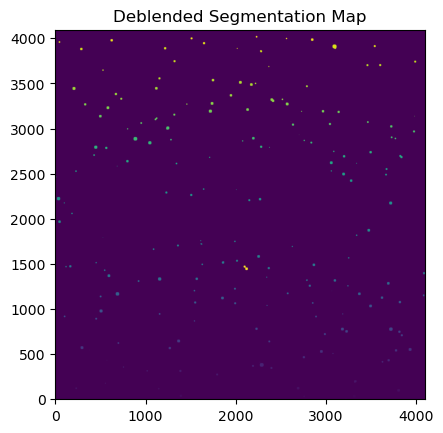

<photutils.segmentation.core.SegmentationImage>
shape: (4096, 4096)
nlabels: 195
labels: [  1   2   3   4   5 ... 191 192 193 194 195]


In [19]:
deblended_segmap31 = photoseg.deblend_sources(convolved_data31, segment_map31, npixels=25, nlevels = 32, contrast = 0.001)

plt.imshow(deblended_segmap31)
plt.gca().invert_yaxis()
plt.title("Deblended Segmentation Map")
plt.show()

print(deblended_segmap31)

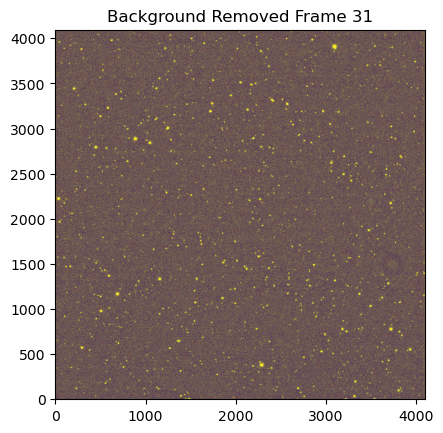

In [20]:
bglessframe31 = np.asarray(frame31) - np.asarray(bgimg31)

plt.imshow(bglessframe31, vmin=0, vmax=50)
plt.title("Background Removed Frame 31")
plt.gca().invert_yaxis()
plt.show()

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


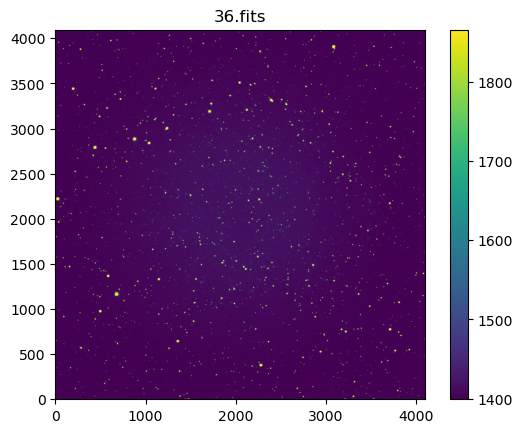

In [21]:
frame36 = astropy.nddata.CCDData.read("data/science_R_cali/20181101.00000036.fits", unit="adu")
plt.imshow(frame36, vmin=1399.2028, vmax=1865.4568)
plt.gca().invert_yaxis()
plt.title("36.fits")
plt.colorbar()
plt.show()

Background Median = 1288.0000000000002 adu
Background rms = 71.79759701888088 adu


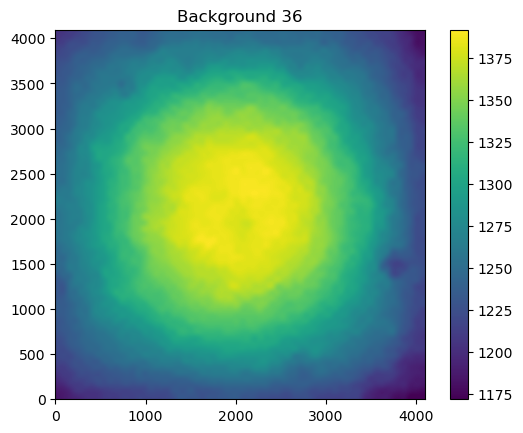

In [22]:
bg36 = photobg.Background2D(frame36, 64, filter_size=3, bkg_estimator=MedianBackground())
bgmedian36 = bg36.background_median
bgrms36 = bg36.background_rms_median
print(f"Background Median = {bgmedian36}")
print(f"Background rms = {bgrms36}")

bgimg36 = bg36.background

plt.imshow(np.asarray(bgimg36), interpolation="nearest")
plt.gca().invert_yaxis()
plt.title("Background 36")
plt.colorbar()
plt.show()

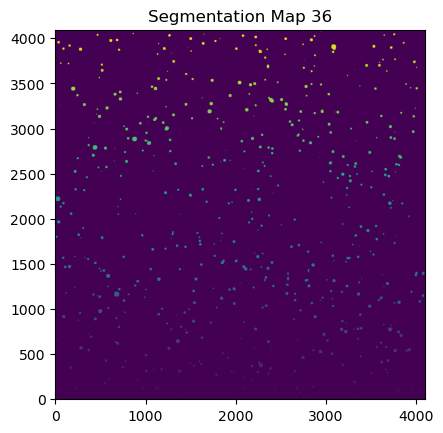

<photutils.segmentation.core.SegmentationImage>
shape: (4096, 4096)
nlabels: 563
labels: [  1   2   3   4   5 ... 559 560 561 562 563]


In [45]:
gaussiankernal36 = photoseg.make_2dgaussian_kernel(25, 25)
threshold36 = bgimg36 + 2 * bgrms36
convolved_data36 = convolve(frame36, gaussiankernal36) * u.adu
segment_map36 = photoseg.detect_sources(convolved_data36, threshold36, npixels=5)

plt.imshow(segment_map36)
plt.gca().invert_yaxis()
plt.title("Segmentation Map 36")
plt.show()

print(segment_map36)

Deblending:   0%|          | 0/533 [00:00<?, ?it/s]

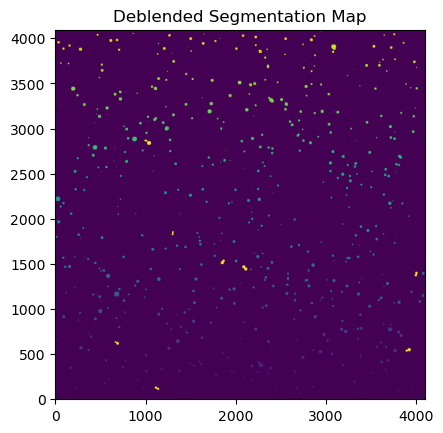

<photutils.segmentation.core.SegmentationImage>
shape: (4096, 4096)
nlabels: 571
labels: [  1   2   3   4   5 ... 567 568 569 570 571]


In [46]:
deblended_segmap36 = photoseg.deblend_sources(convolved_data36, segment_map36, npixels=25, nlevels = 32, contrast = 0.001)

plt.imshow(deblended_segmap36)
plt.gca().invert_yaxis()
plt.title("Deblended Segmentation Map")
plt.show()

print(deblended_segmap36)

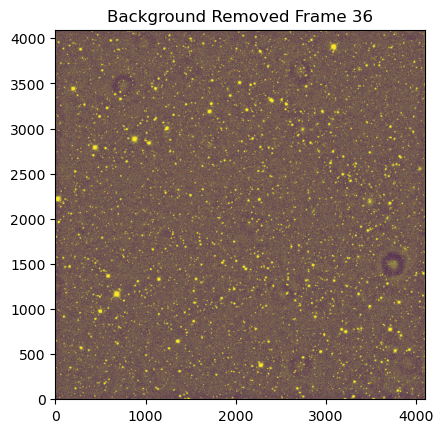

In [47]:
bglessframe36 = np.asarray(frame36) - np.asarray(bgimg36)

plt.imshow(bglessframe36, vmin=0, vmax=50)
plt.title("Background Removed Frame 36")
plt.gca().invert_yaxis()
plt.show()

In [48]:
array31 = np.asarray(bglessframe31)

bgrmsarray31 = bg31.background_rms

totalerror31 = calc_total_error(array31, np.asarray(bgrmsarray31), 2.2)

cat31 = SourceCatalog(array31, deblended_segmap31, convolved_data=np.asarray(convolved_data31), error=totalerror31)

tbl31 = cat31.to_table()

print(tbl31)

label     xcentroid          ycentroid      sky_centroid ...  segment_fluxerr       kron_flux         kron_fluxerr   
                                                         ...                                                         
----- ------------------ ------------------ ------------ ... ------------------ ------------------ ------------------
    1  1485.508411777352  6.540652966135549         None ... 1132.0275499919576 226778.24542682376 1860.0172106281343
    2 3220.8030373301644  7.897649478485721         None ...  901.5416132990072 118624.98319209031 1477.8423839571085
    3  3312.677644536271  30.70213466326436         None ... 1800.5157747289327  552060.4677372668  2754.981089116738
    4   2758.22513685856  28.84963707073882         None ... 1069.9175195808602  89453.26881288274 1829.0192038753457
    5 1393.3473100983535 34.958336605901195         None ... 1477.0509568432678  179740.7744165308 2459.1157515074074
    6  2720.999507645907  73.34358373325047         None

In [49]:
array36 = np.asarray(bglessframe36)

bgrmsarray36 = bg36.background_rms

totalerror36 = calc_total_error(array36, np.asarray(bgrmsarray36), 2.2)

cat36 = SourceCatalog(array36, deblended_segmap36, convolved_data=np.asarray(convolved_data36), error=totalerror36)

tbl36 = cat36.to_table()

print(tbl36)

label     xcentroid          ycentroid      sky_centroid ...  segment_fluxerr       kron_flux         kron_fluxerr   
                                                         ...                                                         
----- ------------------ ------------------ ------------ ... ------------------ ------------------ ------------------
    1 3211.2613011172566  8.194719505012696         None ... 1196.3258825420896  311824.3124424759  2368.254283730676
    2 1476.2804144094612  9.390828719555568         None ...  984.4725647891339  323019.0517902494   3221.17524919279
    3  3529.233997197103  10.64180284892656         None ...  968.9370348174223 210195.83028438332  3176.331280867536
    4 1439.3113374935383  11.34960194492718         None ...  387.8813338950168    4213.2848227252  1218.829239542292
    5 1966.3774972407766 16.745287436331505         None ...  762.2151698140817   74083.5161364513 1310.7466329139056
    6 3303.4030611727894 28.347762130093475         None

In [83]:
axy = fits.open('data/astronomy.net stuff/corr.fits')

axyarray = axy[1].data

axy.close()

#290.19968668, 44.15522421

xpos31 = cat31.xcentroid
ypos31 = cat31.ycentroid
flux31 = cat31.segment_flux
coords31 = []

for i in range(len(xpos31)):
    coords31.append([xpos31[i], ypos31[i], flux31[i]])

bestpos31 = [5000, 5000]

for source in coords31:
    if ( abs(source[0] - 3094.18847656) < abs(bestpos31[0] - 3094.18847656) and abs(source[1] - 3903.71337891) < abs(bestpos31[1] - 3903.71337891) ):
        bestpos31 = source

#print(bestpos)
#print(axyarray)

instrmag31 = -2.5 * np.log10(bestpos31[2])

#print(instrmag)

B_mag = 10.03 #from https://simbad.u-strasbg.fr/simbad/sim-coo?Coord=290.19968668+44.15522421&Radius=2&Radius.unit=arcmin&submit=submit+query

zp_B = B_mag - instrmag31

print(f"180 Second Instrumental Zero Point (B Filter) = {zp_B}")

[3093.6632158027737, 3902.3978773907584, 6077758.820662817]
180 Second Instrumental Zero Point (B Filter) = 26.989358655724786


In [114]:
axy = fits.open('data/astronomy.net stuff/axyR.fits')
axyarray = axy[1].data
axy.close()

radec = fits.open('data/astronomy.net stuff/image-radecR.fits')
radecarr = radec[1].data
radec.close()

#19 19 18.1471807608	+43 47 54.262891716
#289.8256133, 43.79840636

#print(axyarray[0])
#print(radecarr[0])

temp = [0, 0, 100000000000000000, 1000000000000000000]

for source in radecarr:
    if ( abs(source[2] - 289.8256133) < abs(temp[2] - 289.8256133) and abs(source[3] - 43.79840636) < abs(temp[3] - 43.79840636) ):
        temp = source

#print(temp)

xpos36 = cat36.xcentroid
ypos36 = cat36.ycentroid
flux36 = cat36.segment_flux
coords36 = []

for i in range(len(xpos36)):
    coords36.append([xpos36[i], ypos36[i], flux36[i]])

bestpos36 = [5000, 5000]

for source in coords36:
    if ( abs(source[0] - temp[2]) < abs(bestpos36[0] - temp[2]) and abs(source[1] - temp[3]) < abs(bestpos36[1] - temp[3]) ):
        bestpos36 = source

#print(bestpos36)

instrmag36 = -2.5 * np.log10(bestpos36[2])

#print(instrmag36)

R_mag = 10.03 #from https://simbad.u-strasbg.fr/simbad/sim-coo?Coord=290.19968668+44.15522421&Radius=2&Radius.unit=arcmin&submit=submit+query

zp_R = R_mag - instrmag

print(f"180 Second Instrumental Zero Point (R Filter) = {zp_R}")

180 Second Instrumental Zero Point (R Filter) = 26.989358655724786
